# Siamese Network for Image Retrieval System
In this notebook we will use a siamese network to retrieve images from a database based on a query image.

In [1]:
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle
from PIL import Image

## Create a Dataset
For a siamese network, the dataset is structured in such a way that every sample has two images and one label whose value determines if the images are same or different.

In [2]:
def imread(image_path, target_size=(225, 225)):
    """Load an image and preprocess it"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

def create_siamese_dataset(data_dir, pairs_per_classes=100):
    """Given a dataset in standard classification format, create
    a dataset for siamese architecture"""
    classes = os.listdir(data_dir)
    num_classes = len(classes)
    pairs = []
    labels = []

    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        images = os.listdir(class_dir)

        for i in range(pairs_per_classes):
            # Select two different images randomly from the same class
            anchor_image_name = random.choice(images)
            positive_image_name = random.choice(images)
            while positive_image_name == anchor_image_name:
                positive_image_name = random.choice(images)
            anchor_image_path = os.path.join(class_dir, anchor_image_name)
            positive_image_path = os.path.join(class_dir, positive_image_name)
            anchor_image = imread(anchor_image_path)
            positive_image = imread(positive_image_path)
            pairs.append([anchor_image, positive_image])
            labels.append(1) # for similar images

            # Select a different class for negative pair
            negative_class_idx = random.randint(0, num_classes - 1)
            while negative_class_idx == class_idx:
                negative_class_idx = random.randint(0, num_classes - 1)
            negative_class_name = classes[negative_class_idx]
            negative_class_dir = os.path.join(data_dir, negative_class_name)
            negative_image_name = random.choice(os.listdir(negative_class_dir))
            negative_image_path = os.path.join(
                negative_class_dir, negative_image_name)
            negative_image = imread(negative_image_path)
            pairs.append([anchor_image, negative_image])
            labels.append(0)  # dissimilar images

    return np.array(pairs), np.array(labels)

In [3]:
# Create dataset based on images in the specified path
data_dir = "datasets/siamese_dataset/data"
X, y = create_siamese_dataset(data_dir, pairs_per_classes=100)

# shuffle the dataset
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]
print(f"[INFO]: Siamese dataset contains {len(X)} samples, where each sample has the shape {X[0].shape}")

[INFO]: Siamese dataset contains 1400 samples, where each sample has the shape (2, 225, 225, 3)


## Visualization
Let's plot a single sample from the dataset, chosen randomly.

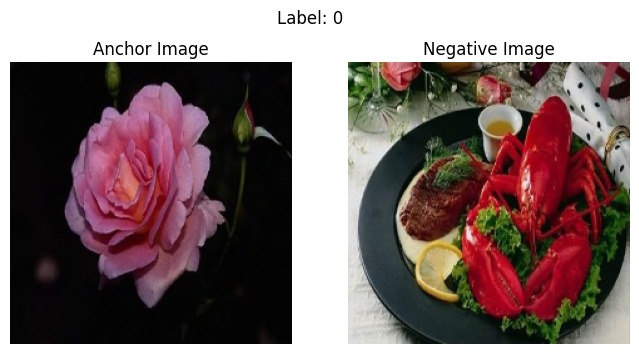

In [4]:
image_idx = random.randint(0, len(X)-1)
title = "Positive Image" if y[image_idx] == 1 else "Negative Image"
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(X[image_idx][0])
plt.title("Anchor Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X[image_idx][1])
plt.title(title)
plt.axis('off')

plt.suptitle(f'Label: {y[image_idx]}')
plt.show()


## Siamese Network Architecture
In siamese network, we have two identical neural networks, each is called a branch or twin.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 225, 225, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,432,768 (196.20 MB)

 Trainable params: 51,432,768 (196.20 MB)

 Non-trainable params: 0 (0.00 B)

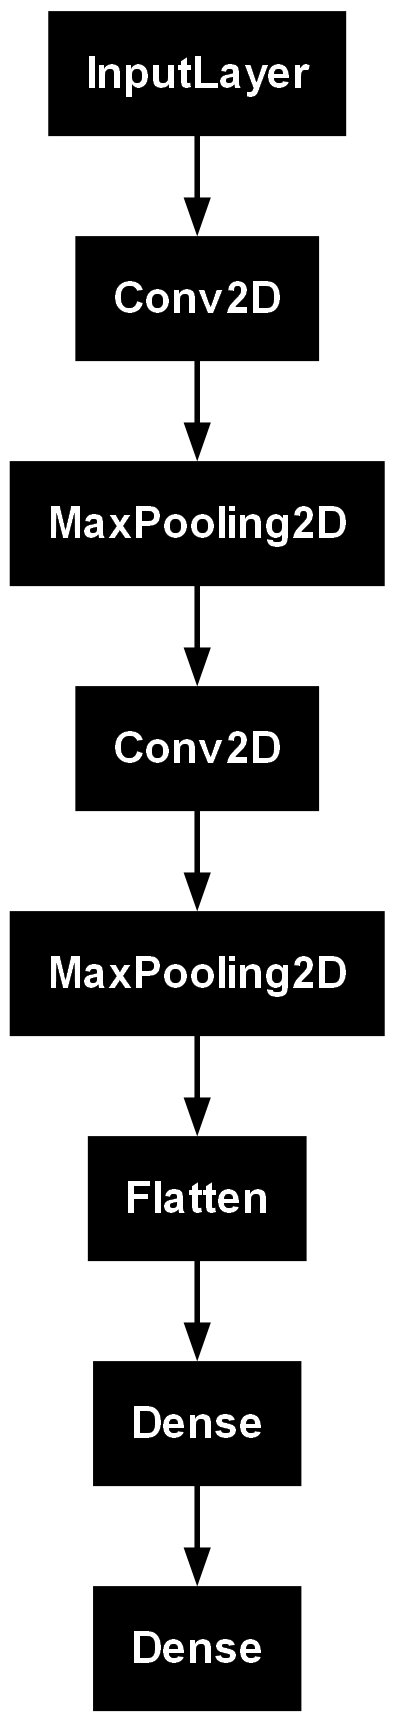

In [5]:
def siamese_branch(input_shape):
    """A single branch of siamese network"""
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(input)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    embedding = layers.Dense(128)(x)
    return tf.keras.Model(inputs=input, outputs=embedding)

siamese_branch = siamese_branch((225, 225, 3))
siamese_branch.summary()
tf.keras.utils.plot_model(siamese_branch)

In [6]:
def similarity(embeddings):
    """Using euclidean distance as the similarity metric"""
    squared_diff = tf.square(embeddings[0] - embeddings[1])
    squared_sum = tf.reduce_sum(squared_diff, axis=1)
    euclidean_distance = tf.sqrt(squared_sum)
    return euclidean_distance

def similarity_out_shape(shapes):
    """Output shape of the layer which calculates the similarity
    metric for the embeddings from the two branches"""
    return (shapes[0][0], 1)

### Combining two Siamese Branches to create a Complete Network
This model takes an image pair and outputs how similar those images are.

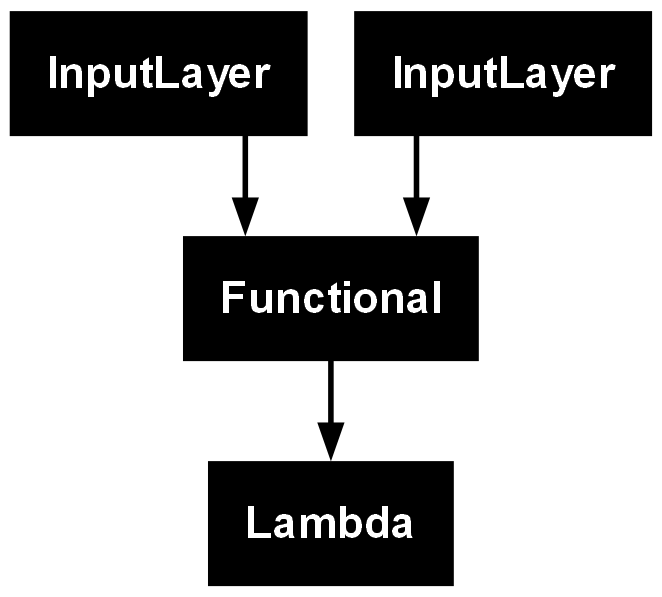

In [9]:
inputa = layers.Input(shape=(225, 225, 3))
inputb = layers.Input(shape=(225, 225, 3))
embeddinga = siamese_branch(inputa)
embeddingb = siamese_branch(inputb)
similarity_output = layers.Lambda(similarity, output_shape=similarity_out_shape)([embeddinga, embeddingb])
siamese_model = tf.keras.Model([inputa, inputb], similarity_output)
tf.keras.utils.plot_model(siamese_model)


In [10]:
def contrastive_loss(y_true, y_pred, margin=0.3):
    """Loss function that will punish the network for giving low score(l2) for
    dissimilar images and vice versa"""
    y_true = tf.cast(y_true, tf.float32)
    squared_pred = tf.square(y_pred)
    margin_squared = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * squared_pred + (1 - y_true) * margin_squared)

## Model Training
 will train the model for 25 epochs using Adam optimizer

In [12]:
optimizer = tf.keras.optimizers.Adam()
siamese_model.compile(optimizer=optimizer, loss=contrastive_loss)

In [13]:
history = siamese_model.fit([X[:, 0], X[:, 1]],
                                y, batch_size=32, epochs=20)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - loss: 9.2707
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 0.0378
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - loss: 0.0177
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - loss: 0.0154
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - loss: 0.0140
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - loss: 0.0113
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - loss: 0.0095
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - loss: 0.0079
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 0.0065
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 0.0057
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 0.0047
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 0.0043
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 0.0038
Epoch 14/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - loss: 0.0035
Epoch 15/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 0.0035
Epoch 16/20
44/4

In [31]:
# Save the trained model
siamese_branch.save('models/SiameseBranch.keras')

In [32]:
# load the trained model
custom_objects = {
    'similarity': similarity,
    'similarity_out_shape': similarity_out_shape,
    'contrastive_loss': contrastive_loss
    }
model = models.load_model('models/SiameseBranch.keras',)

## Feature Extraction and Indexing
We will use the trained network to extract the features for all images in the database and store them or index them for downstream tasks like retrieval

In [24]:
def extract_features(img, model):
    """Extract feature vector for an image"""
    img = imread(img)
    feature_vector = model(np.expand_dims(img, axis=0))
    return feature_vector.numpy().flatten()

images_folder = 'datasets/Images/data'
image_features = {}

# Iterate over each image in the folder and extract features
for filename in os.listdir(images_folder):
    image_path = os.path.join(images_folder, filename)
    features = extract_features(image_path, siamese_branch)
    image_features[filename] = features

# Save the image features dictionary as a pickle object
pickle_file = "image_features.pkl"
with open(pickle_file, 'wb') as f:
    pickle.dump(image_features, f)
print("Image features extracted and saved successfully.")

Image features extracted and saved successfully.


In [ ]:
# load the image features from the database
with open(pickle_file, 'rb') as f:
    image_features = pickle.load(f)
    print('Image features loaded successfully')

Image features loaded successfully


In [33]:
def euclidean_distance(query_vector, image_vectors):
    """Compute the similarity between query image and database images"""
    distances = np.linalg.norm(image_vectors - query_vector, axis=1)
    return distances

def retrieve_similar_images(query_image):
    """Retrieve top 20 similar images from the database based on the query image"""
    query_vector = extract_features(query_image, model)
    similarities = euclidean_distance(query_vector, np.array(list(image_features.values())))
    sorted_indices = np.argsort(similarities)

    similar_image_names = [list(image_features.keys())[i] for i in sorted_indices[:20]]
    plt.figure(figsize=(15, 12))
    for i, image_name in enumerate(similar_image_names):
        image = Image.open(f'datasets/Images/data/{image_name}')
        plt.subplot(4, 5, i+1)
        plt.imshow(image)
        plt.title(image_name)
        plt.axis('off')
    plt.show()

## Using Siamese Network for Image retrieval

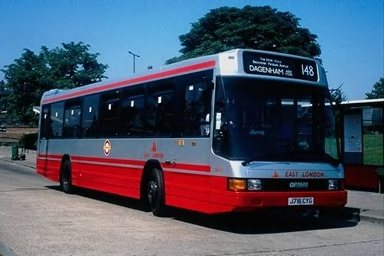

In [34]:
query_image_path = 'datasets/images/data/301.jpg'
query_image = Image.open(query_image_path)
query_image

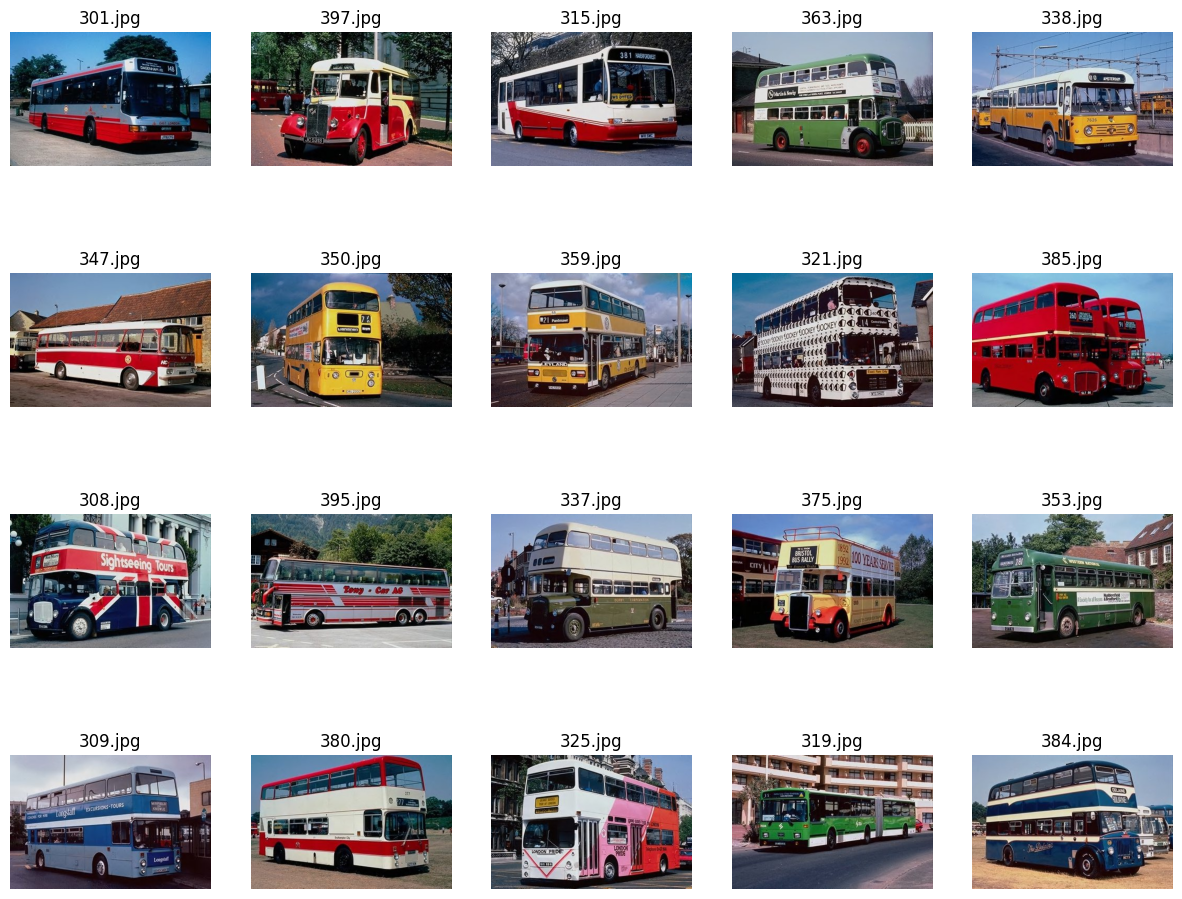

In [35]:
retrieve_similar_images(query_image=query_image_path)